In [1]:
import torch
import onnxruntime
import cv2
import numpy as np
import numba as nb


@nb.njit('int64[:](float32[:,:], float32[:], float32, bool_)', fastmath=True, cache=True)
def nms_cpu(boxes, confs, nms_thresh, min_mode):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1) * (y2 - y1)
    order = confs.argsort()[::-1]
    keep = []
    while order.size > 0:
        idx_self = order[0]
        idx_other = order[1:]
        keep.append(idx_self)
        xx1 = np.maximum(x1[idx_self], x1[idx_other])
        yy1 = np.maximum(y1[idx_self], y1[idx_other])
        xx2 = np.minimum(x2[idx_self], x2[idx_other])
        yy2 = np.minimum(y2[idx_self], y2[idx_other])
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        if min_mode:
            over = inter / np.minimum(areas[order[0]], areas[order[1:]])
        else:
            over = inter / (areas[order[0]] + areas[order[1:]] - inter)
        inds = np.where(over <= nms_thresh)[0]
        order = order[inds + 1]
    return np.array(keep).astype(np.int64)

def resize_and_pad_image(image_data, target_hw, pad_value=0):
    image_hw = image_data.shape[:2]
    image_scale = min(target_hw[0] / image_hw[0], target_hw[1] / image_hw[1])
    new_h = int(image_hw[0] * image_scale)
    new_w = int(image_hw[1] * image_scale)
    image_data_scaled = cv2.resize(image_data, (new_w, new_h))
    pad_top = (target_hw[0] - new_h) // 2
    pad_bottom = target_hw[0] - new_h - pad_top
    pad_left = (target_hw[1] - new_w) // 2
    pad_right = target_hw[1] - new_w - pad_left
    image_data_padded = cv2.copyMakeBorder(image_data_scaled, pad_top, pad_bottom, pad_left, pad_right,
                                         borderType=cv2.BORDER_CONSTANT, value=pad_value)
    assert image_data_padded.shape[:2] == target_hw
    pad_list = np.array([pad_top, pad_bottom, pad_left, pad_right, image_scale]).astype(np.float32)
    return image_data_padded, pad_list

def recover_original_box(head_box, pad_list, original_hw):
    pad_top, pad_bottom, pad_left, pad_right, image_scale = pad_list
    x_min = (head_box[0] - pad_left) / image_scale
    y_min = (head_box[1] - pad_top) / image_scale
    x_max = (head_box[2] - pad_left) / image_scale
    y_max = (head_box[3] - pad_top) / image_scale
    # enlarge the bbox to include more background margin
    y_min = max(0, y_min - abs(y_min - y_max) / 10)
    y_max = min(original_hw[0], y_max + abs(y_min - y_max) / 10)
    y_center = (y_min + y_max) / 2
    y_delta = (y_max - y_min) / 2
    x_min = max(0, x_min - abs(x_min - x_max) / 5)
    x_max = min(original_hw[1], x_max + abs(x_min - x_max) / 5)
    x_max = min(x_max, original_hw[1])
    x_center = (x_min + x_max) / 2
    x_delta = (x_max - x_min) / 2
    xy_delta = max(x_delta, y_delta)
    y_min = max(0, y_center - xy_delta)
    y_max = min(original_hw[0], y_center + xy_delta)
    x_min = max(0, x_center - xy_delta)
    x_max = min(original_hw[1], x_center + xy_delta)
    image_head_width = (x_max - x_min)
    image_head_height = (y_max - y_min)
    image_head_width = max(image_head_width, image_head_height)
    image_head_height = image_head_width
    image_head_cx = ((x_min + x_max) / 2.)
    image_head_cy = ((y_min + y_max) / 2.)
    x1, y1 = image_head_cx - image_head_width / 2, image_head_cy - image_head_height / 2
    x2, y2 = image_head_cx + image_head_width / 2, image_head_cy + image_head_height / 2
    x1, y1, x2, y2 = max(0, x1), max(0, y1), min(original_hw[1], x2), min(original_hw[0], y2)
    half_w = min(abs(x1 - image_head_cx), abs(x2 - image_head_cx))
    half_h = min(abs(y1 - image_head_cy), abs(y2 - image_head_cy))
    image_head_width, image_head_height = 2. * half_w, 2. * half_h
    return np.array([x1, y1, image_head_width, image_head_height, head_box[4]]).astype(np.float32)

class YoloHeadDetector(object):
    def __init__(self, weights_file: str, input_width: int=640, input_height: int=480) -> None:
        self.weights_file = weights_file
        self.providers = ['CPUExecutionProvider']
        if torch.cuda.is_available():
            self.providers.insert(0, 'CUDAExecutionProvider')
        self.detector = onnxruntime.InferenceSession(self.weights_file, providers=self.providers)
        self.input_width = input_width
        self.input_height = input_height
        self.input_hw = (self.input_height, self.input_width)
        self.input_name = self.detector.get_inputs()[0].name
        self.output_names = [output.name for output in self.detector.get_outputs()]
        self.output_shapes = [output.shape for output in self.detector.get_outputs()]
        assert self.output_shapes[0] == [1, 18900, 1, 4] # boxes[N, num, classes, boxes]
        assert self.output_shapes[1] == [1, 18900, 1]    # confs[N, num, classes]
        self.conf_thresh = 0.60
        self.nms_thresh = 0.50

    def __call__(self, image_data: np.ndarray, isBGR: bool) -> np.ndarray:
        if isBGR: image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
        image_data_padded, pad_list = resize_and_pad_image(image_data, self.input_hw, pad_value=0)
        image_data_chw = image_data_padded.transpose(2, 0, 1).astype(np.float32) / 255.
        image_data_boxes, image_data_confs = self.detector.run(
            output_names=self.output_names, input_feed={self.input_name: image_data_chw[np.newaxis, ...]}
        )
        image_data_boxes, image_data_confs = image_data_boxes[0][:, 0, :], image_data_confs[0][:, 0]
        argwhere = image_data_confs > self.conf_thresh
        image_data_boxes, image_data_confs = image_data_boxes[argwhere, :], image_data_confs[argwhere]
        image_data_heads = []
        image_data_keep = nms_cpu(
            boxes=image_data_boxes, confs=image_data_confs, nms_thresh=self.nms_thresh, min_mode=False
        )
        if image_data_keep.size == 0: print('No object detected!'); return None
        width = image_data_padded.shape[1]
        height = image_data_padded.shape[0]
        if (image_data_keep.size > 0):
            image_data_boxes, image_data_confs = image_data_boxes[image_data_keep, :], image_data_confs[image_data_keep]
            for k in range(image_data_boxes.shape[0]):
                image_data_heads.append([image_data_boxes[k, 0] * width, image_data_boxes[k, 1] * height,
                                       image_data_boxes[k, 2] * width, image_data_boxes[k, 3] * height,
                                       image_data_confs[k]])
        original_hw, image_data_heads_ = image_data.shape[:2], []
        for idx in range(len(image_data_heads)):
            image_data_heads_.append(recover_original_box(image_data_heads[idx], pad_list, original_hw))
        return np.array(image_data_heads_).astype(np.float32)

In [2]:
hdet = YoloHeadDetector(weights_file='assets/224x224_yolov4_hddet_480x640.onnx',
                        input_width=640, input_height=480)

  0%|          | 0/6 [00:00<?, ?it/s]

samples/000031.png, x, y, w, h, score: 15.300369 63.336704 936.70715 936.70715 0.87663114


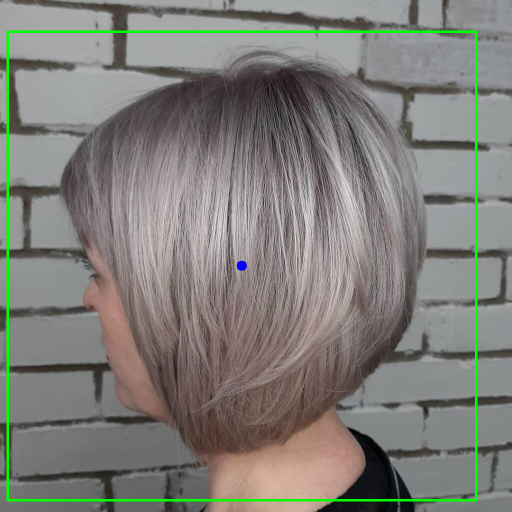

 17%|█▋        | 1/6 [00:08<00:40,  8.04s/it]

samples/man.jpg, x, y, w, h, score: 762.2183 0.0 3274.3633 3274.3633 0.9764795


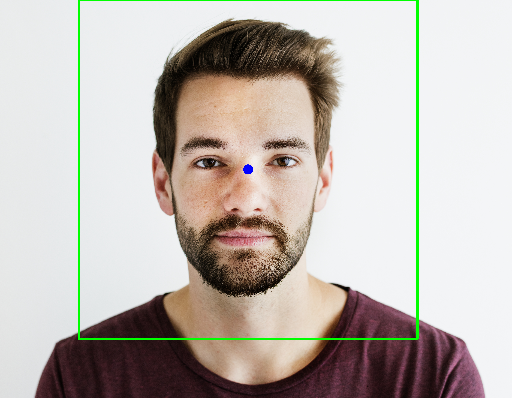

 33%|███▎      | 2/6 [00:08<00:14,  3.60s/it]

samples/woman.jpg, x, y, w, h, score: 2247.418 167.8536 2464.455 2464.455 0.9182032


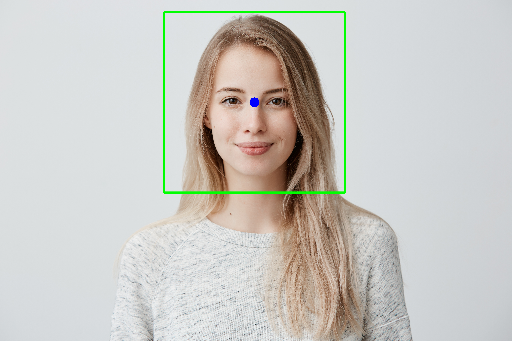

 50%|█████     | 3/6 [00:09<00:06,  2.22s/it]

samples/000013.png, x, y, w, h, score: 59.038147 54.642826 335.7936 335.7936 0.94425017


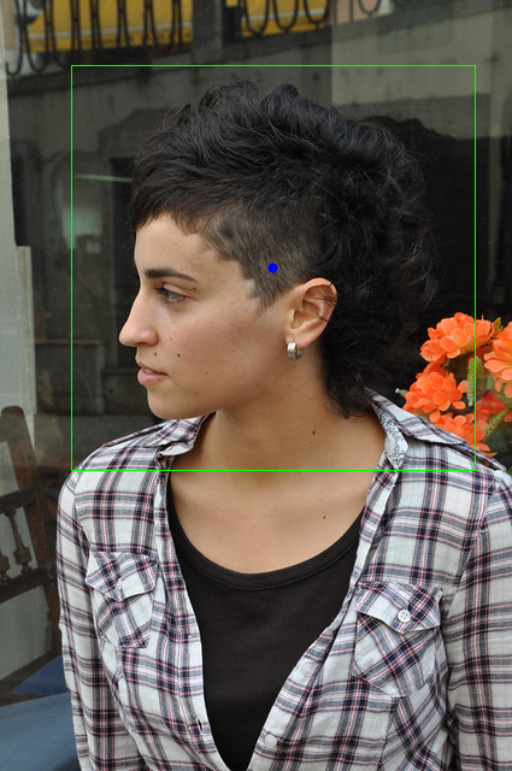

 67%|██████▋   | 4/6 [00:09<00:02,  1.40s/it]

samples/000007.png, x, y, w, h, score: 0.0 0.0 361.67276 384.28665 0.8468978


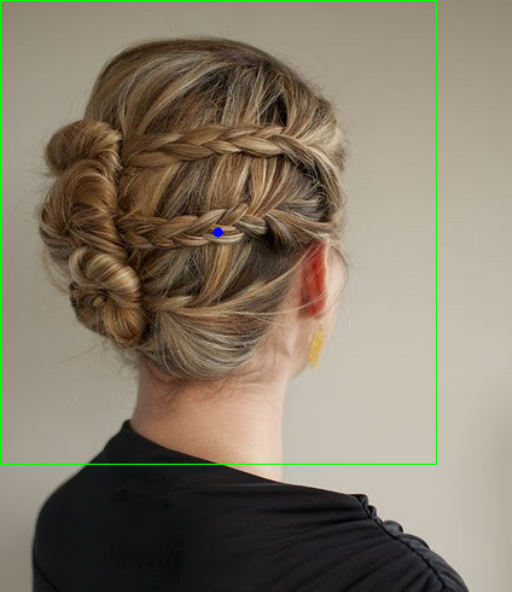

samples/000060.png, x, y, w, h, score: 0.0 0.0 500.0 528.37634 0.6440434


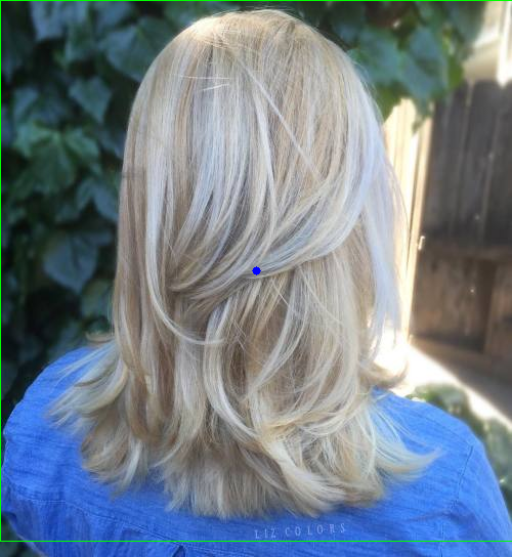

100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


In [3]:
import tqdm
import os
import os.path as osp
from PIL import Image

image_dir = 'samples'
image_files = os.listdir(image_dir)
for image_file in tqdm.tqdm(image_files):
    image_path = osp.join(image_dir, image_file)
    image_data = cv2.imread(image_path)
    image_boxes = hdet(image_data.copy(), isBGR=True)
    for box in image_boxes:
        x, y, w, h, score = box
        cx, cy = x + w/2, y + h/2
        # visualize
        print(f'{image_path}, x, y, w, h, score:', x, y, w, h, score)
        image_w, image_h = image_data.shape[:2]
        scale = 512/image_h
        vis_image = image_data.copy()
        vis_image = cv2.rectangle(vis_image, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 0), int(2/scale)) # bgr
        vis_image = cv2.circle(vis_image, (int(cx), int(cy)), int(5/scale), (255, 0, 0), -1) # bgr
        vis_image = cv2.resize(vis_image, (0, 0), fx=scale, fy=scale)
        display(Image.fromarray(vis_image[..., ::-1]))
